In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

In [6]:
file_path = '../data/kaggle/student-mat.csv'
data = pd.read_csv(file_path, sep=';')
data.head()
     

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [7]:
print("\nChecking for missing values:")
print(data.isnull().sum())
     


Checking for missing values:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


In [8]:

# Drop duplicates if any
data = data.drop_duplicates()
print("\nNumber of rows after removing duplicates:", data.shape[0])


Number of rows after removing duplicates: 395


In [9]:
# Feature selection and preprocessing
features = data.drop(columns=['G3'])
labels = data['G3']
data_numeric = data
# Convert categorical features to numerical with binary dummy variables
categorical_cols = features.select_dtypes(exclude=['number']).columns
features = pd.get_dummies(features, columns=categorical_cols, drop_first=True).astype(int)

data_numeric = pd.get_dummies(data_numeric, columns=categorical_cols, drop_first=True).astype(int)
labels = np.where(labels >= 10, 1, 0)

In [10]:
# Select only numeric columns for correlation calculation
numeric_columns = data_numeric.select_dtypes(include=[np.number])

# Calculate correlation for numerical features
correlation = numeric_columns.corr()
print("\nCorrelation with target variable G3:")
print(correlation['G3'].sort_values(ascending=False))

# Identify features with low correlation (threshold < 0.1)
low_corr_features = correlation['G3'][abs(correlation['G3']) < 0.1].index
low_corr_features = low_corr_features.difference(['studytime','internet_yes'])

# Drop these features from the dataset
features = features.drop(columns=low_corr_features, errors='ignore')
print("\nFeatures dropped due to low correlation:", list(low_corr_features))
     


Correlation with target variable G3:
G3                   1.000000
G2                   0.904868
G1                   0.801468
Medu                 0.217147
higher_yes           0.182465
Fedu                 0.152457
Mjob_health          0.116158
address_U            0.105756
sex_M                0.103456
paid_yes             0.101996
internet_yes         0.098483
studytime            0.097820
reason_reputation    0.095692
Fjob_teacher         0.095374
famsize_LE3          0.081407
Mjob_services        0.078429
Mjob_teacher         0.057712
Fjob_health          0.057111
reason_other         0.052008
nursery_yes          0.051568
famrel               0.051363
absences             0.034247
guardian_mother      0.022338
activities_yes       0.016100
freetime             0.011307
Fjob_services       -0.016108
reason_home         -0.021359
famsup_yes          -0.039157
school_MS           -0.045017
Walc                -0.051939
Fjob_other          -0.053483
Dalc                -0.054660
Ps

In [11]:
# Split data into train and test sets for further modelingX_scaled
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [12]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [14]:

# Define the SVM model
svm_model = SVC(kernel='rbf', C=1000, gamma=0.001, probability=True, class_weight='balanced')

In [15]:
# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-validation accuracy scores:", cross_val_scores)
print("Mean cross-validation accuracy:", np.mean(cross_val_scores))

Cross-validation accuracy scores: [0.97674419 0.97674419 0.90697674 0.81395349 0.90697674 1.
 0.92857143 0.92857143 0.97619048 0.92857143]
Mean cross-validation accuracy: 0.9343300110741971


In [16]:

# Train the model
svm_model.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced', gamma=0.001, probability=True)

In [17]:
# Evaluate the model
y_pred = svm_model.predict(X_test)



In [18]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[23  4]
 [ 4 48]]


In [19]:

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.92      0.92      0.92        52

    accuracy                           0.90        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.90      0.90      0.90        79



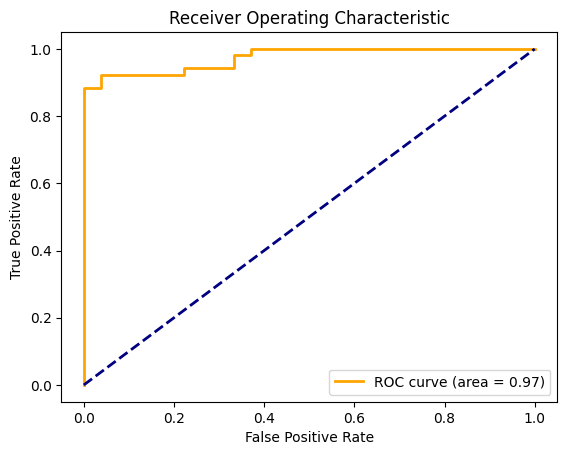

In [20]:
# ROC curve
y_prob = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameters found:  {'C': 1000, 'gamma': 0.001}
Best cross-validation accuracy:  0.9391472868217055
Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.92      0.92      0.92        52

    accuracy                           0.90        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.90      0.90      0.90        79



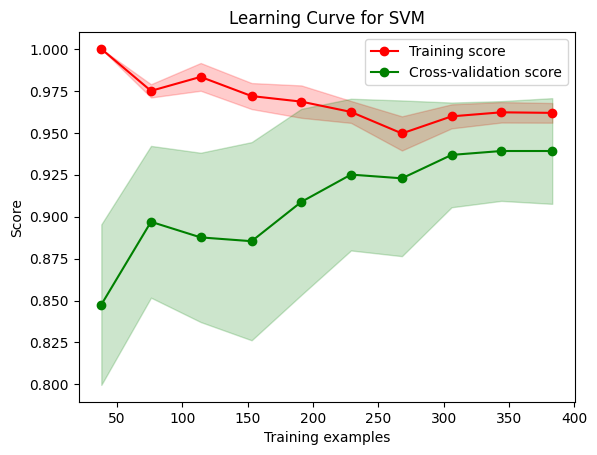

In [21]:
from sklearn.model_selection import GridSearchCV, learning_curve

# Define the SVM model with initial parameters
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')

# Perform Grid Search to find optimal hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100,1000,5000,10000,100000],
    'gamma': [1, 0.1, 0.01, 0.001,0.005,0.0001,0.00001,0.000001]
}
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Re-train the model with best parameters
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = best_svm_model.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, y_pred))

# Plot validation curves for 'C' and 'gamma'
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.2)
plt.title("Learning Curve for SVM")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

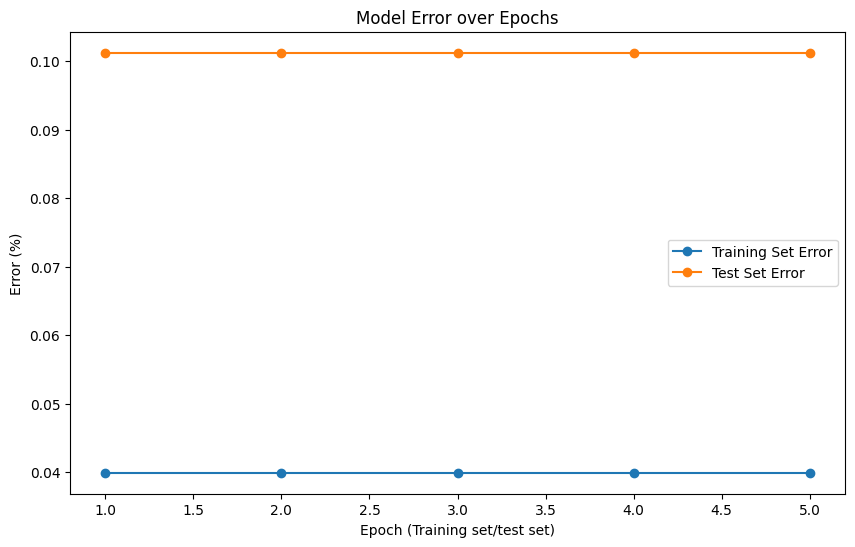

In [23]:
epochs = 5
train_errors = []
test_errors = []

for epoch in range(epochs):
    # Train the model for the current epoch
    svm_model.fit(X_train, y_train)

    # Calculate training error
    train_pred = svm_model.predict(X_train)
    train_error = 1 - np.mean(train_pred == y_train)
    train_errors.append(train_error)

    # Calculate test error
    test_pred = svm_model.predict(X_test)
    test_error = 1 - np.mean(test_pred == y_test)
    test_errors.append(test_error)

# Plotting the error chart
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_errors, label="Training Set Error", marker='o')
plt.plot(range(1, epochs + 1), test_errors, label="Test Set Error", marker='o')
plt.xlabel("Epoch (Training set/test set)")
plt.ylabel("Error (%)")
plt.title("Model Error over Epochs")
plt.legend()
plt.show()